<hr/><b>Project:</b> CNN-based detection of geometric shapes in images <br/> <b>Author:</b> Patrick Hammer <br/><b>Time:</b> November 2019<hr/>

Always needs to be evaluated, defines the image size, how many images, as well as the labels:

In [17]:
#DATA TO GENERATE
import cairo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
#Set seeds:
random.seed(1337)
np.random.seed(1337)
#Amount of images and their size:
n_imgs = 30000
img_size = 32
#Min/max object size and how far ellipses can be strechted dependent on padding:
min_object_size = 12
min_ellipse_stretch = 0.3
padding = 9
img_size_padded = img_size - padding
max_object_size = img_size-2*padding
#Space for the images which we will generate:
imgs = np.zeros((n_imgs, img_size, img_size, 4), dtype=np.uint8) #BGRA
#The labels we will use:
shapes = np.zeros(n_imgs, dtype=int)
shapes_base = ["rectangle", "circle", "triangle", ""] #"" means invalid class
shape_labels = []
for x in shapes_base:
    #There is a filled class for each shape: (except the invalid one)
    if x != "":
        shape_labels.append({"name": x, "fillment": "filled"})
    #And an unfilled class:
    shape_labels.append({"name": x, "fillment": "unfilled"})
n_shapes = len(shape_labels)

Since ShapeNet uses ancient dependencies and a Python version not compatible with current Python2 and Python3, I rebuilt its shape generation process and used Cairo, an OS-independent library to generate the shapes:

In [18]:
#DATA GENERATOR
for i_img in range(n_imgs):
    #Create white background cairo drawing context based on array we allocated:
    surface = cairo.ImageSurface.create_for_data(imgs[i_img], cairo.FORMAT_ARGB32, img_size, img_size)
    cr = cairo.Context(surface)
    cr.set_source_rgb(1, 1, 1)
    cr.paint()
    #Retrieve label info to know what to generate:
    j_shape = np.random.randint(n_shapes)
    shape = shape_labels[j_shape]
    shapes[i_img] = j_shape
    angle = random.random()*2*np.pi
    #Save cairo context: (the current coordinate system essentially before we apply 2D transforms)
    cr.save()
    #Sample the parameters for drawing the primitives:
    w, h = np.random.randint(min_object_size, max_object_size, size=2)
    x = padding+np.random.randint(0, img_size_padded - w)
    y = padding+np.random.randint(0, img_size_padded - h)
    r = np.random.randint(min_object_size, max_object_size)/2.0
    #We use them, but for the invalid class, we draw the shape half-outside of the image:
    draw_as = shape["name"]
    if draw_as == "":
        draw_as = random.choice(shapes_base)
        LeftOrRight = random.choice(["left","right"])
        OUT_MIN = 0
        OUT_MAX = 1
        if LeftOrRight == "left":
            x = np.random.randint(-OUT_MAX, -OUT_MIN)
        else:
            x = np.random.randint(img_size+OUT_MIN, img_size+OUT_MAX)
        UpOrDown = random.choice(["up","down"])
        if LeftOrRight == "up":
            y = np.random.randint(-OUT_MAX, -OUT_MIN)
        else:
            y = np.random.randint(img_size+OUT_MIN, img_size+OUT_MAX)
    #Draw the primitives:
    if draw_as == "line":
        cr.translate(x, y)
        cr.rotate(angle)
        cr.line_to(-w/2, 0)
        cr.line_to(w/2, 0)
    elif draw_as == "triangle":
        cr.translate(x, y)
        cr.rotate(angle)
        cr.line_to(w/2, -h/2)
        triangleTopX = random.random()*w - w/2
        cr.line_to(triangleTopX, h/2)
        cr.line_to(-w/2, -h/2)
        cr.close_path()
    if draw_as == "rectangle":
        cr.translate(x, y)
        cr.rotate(angle)
        cr.rectangle(-w/2, -h/2, w, h)
    elif draw_as == "circle":
        cr.translate(x, y)
        cr.rotate(angle)
        cr.scale(1, min_ellipse_stretch+(1-min_ellipse_stretch)*random.random())
        cr.arc(0, 0, r, 0, 2.0*np.pi)
    #Restore cairo context:
    cr.restore()
    #Draw in black:
    cr.set_source_rgb(0, 0, 0)
    #Decide to fill or not to fill based on fillment property:
    if shape["fillment"] == "unfilled":
        cr.stroke()
    else:
        cr.fill()

In [19]:
"n_imgs="+str(n_imgs), "imgs.shape="+str(imgs.shape), "shapes.shape="+str(shapes.shape)

('n_imgs=30000', 'imgs.shape=(30000, 32, 32, 4)', 'shapes.shape=(30000,)')

n_imgs images, of size 32, with 4 color channels (we will only need one color channel though).<br/>
Also n_imgs of shapes are there, good.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


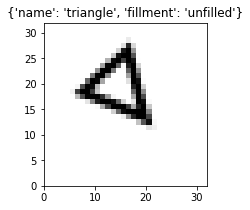

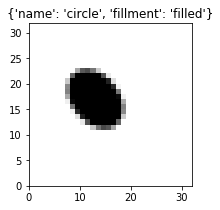

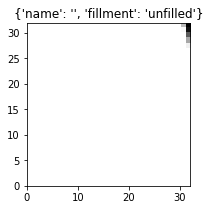

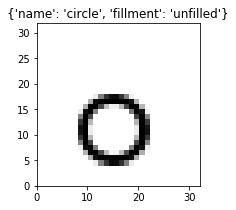

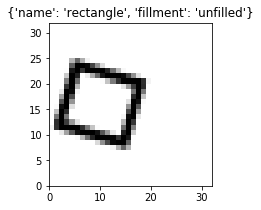

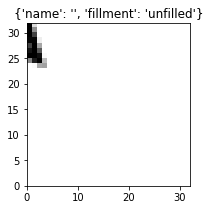

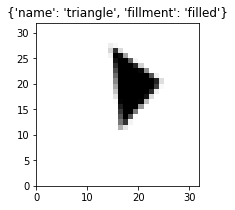

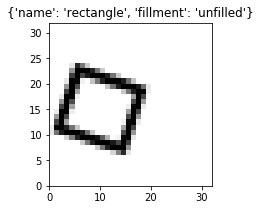

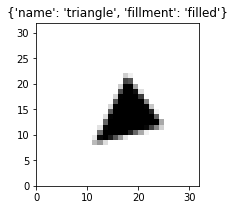

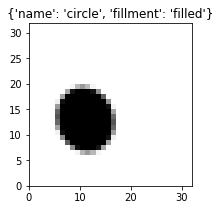

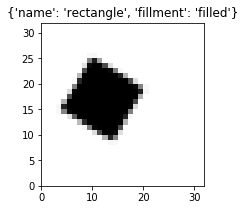

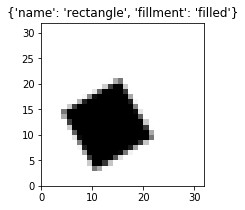

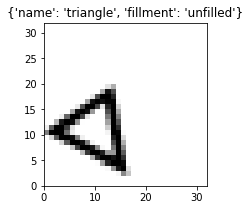

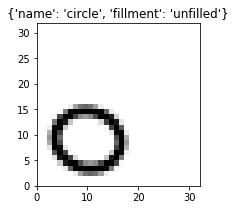

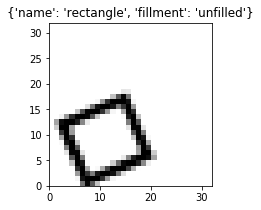

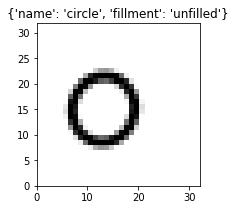

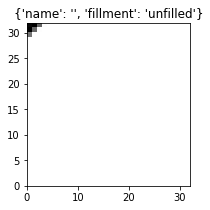

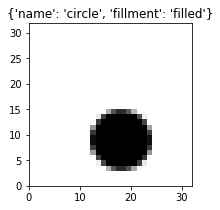

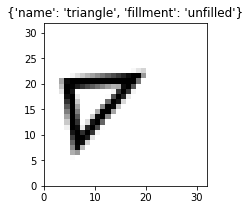

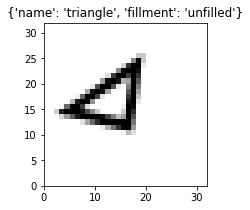

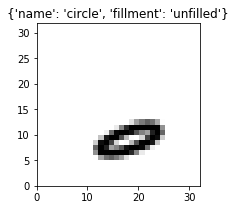

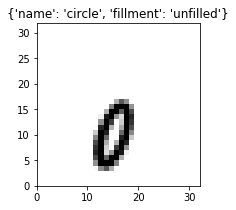

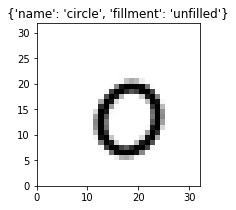

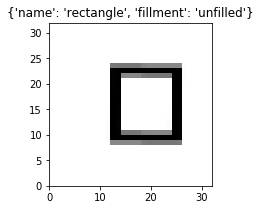

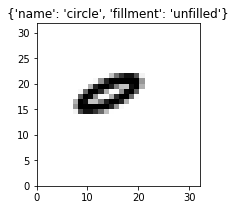

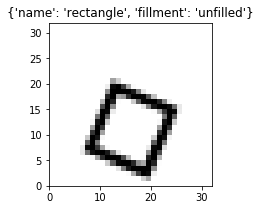

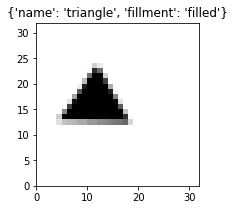

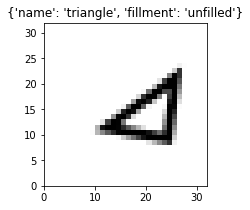

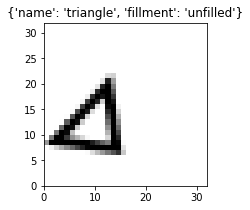

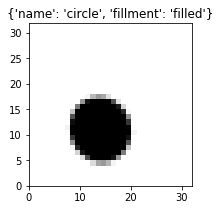

In [20]:
#DRAW GENERATED EXAMPLES
%matplotlib inline
n_display = 30
for i in range(min(n_display,n_imgs)):
    plt.figure(figsize=(3, 3))
    plt.title(shape_labels[shapes[i]])
    plt.imshow(imgs[i], interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])

Next, we want an one-hot vector of the shapes

In [21]:
#GENERATE ONE-HOT ENCODING ANN OUTPUT
shapes_onehot = np.zeros((n_imgs, n_shapes))
for i_img in range(n_imgs):
    shapes_onehot[i_img, shapes[i_img]] = 1
shapes_onehot[0:n_display]

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
 

Looks good!

In [22]:
y = shapes_onehot
y.shape

(30000, 7)

The number of examples, and classes

In [23]:
#TRANSFORM TO UNIT STD and MEAN 0, AND CHECK IT
X = (imgs - np.mean(imgs)) / np.std(imgs) 
X.shape, np.min(X), np.max(X), np.mean(X), np.std(X)

((30000, 32, 32, 4),
 -4.196273343191108,
 0.2696666273077708,
 3.3320105933635585e-16,
 0.9999999999999967)

Correctly rescaled to mean 0 and stddev 1, good

Take 75% as training data. Also we are only interested in 1 channel (black/white!)

In [24]:
#SPLIT INTO TRAIN AND TEST, USE ONLY 1 COLOR CHANNEL
border = int(0.75 * n_imgs)
X_train = X[:border][:,:,:,0:1]
X_test = X[border:][:,:,:,0:1]
y_train = y[:border]
y_test = y[border:]

It's the output of our ANN, an ANN which we have yet to define

Although we will use a sliding window approach on a fixed lattice, we want a convolutional network
to make the network detect patterns not only if they are imperfect but also shifted compared to what the network has seen before. After each layer, maxpooling will be used, which also gives us a bit of tolerance to scaling. Let's get the stone rolling:

In [28]:
#DEFINE CNN
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, MaxPooling2D, Flatten, Conv2D
from keras.optimizers import SGD
from keras.layers.noise import GaussianNoise
#Some model parameters:
first_kernel_size = (5,5)
kernel_size = (3,3)
pool_size = 2
nb_filters = 512
hidden_size = 256
noise=0.5
#Model structure:
model = Sequential([
        Conv2D(filters=nb_filters, kernel_size=first_kernel_size, activation='relu', data_format="channels_last", input_shape=(img_size, img_size, 1)), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(filters=nb_filters, kernel_size=kernel_size, activation='relu', data_format="channels_last"), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(filters=nb_filters, kernel_size=kernel_size, activation='relu', data_format="channels_last"),
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Flatten(),
        Dense(hidden_size, activation='relu'), 
        Dense(hidden_size, activation='relu'), 
        Dense(y.shape[-1], activation='softmax')
])
#Vanilla SGD as we learned it, no magic:
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False)
#Use SGD and cross-entropy loss:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 27, 512)       18944     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 512)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 512)       2359808   
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 512)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 512)         2359808   
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)              

In [29]:
#TRAIN MODEL
batch_size = 64
epochs = 10
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)

Train on 22500 samples, validate on 7500 samples
Epoch 1/10
 - 901s - loss: 1.0420 - acc: 0.6484 - val_loss: 0.6608 - val_acc: 0.7187
Epoch 2/10
 - 928s - loss: 0.4264 - acc: 0.8360 - val_loss: 0.6165 - val_acc: 0.7345
Epoch 3/10
 - 926s - loss: 0.2583 - acc: 0.9114 - val_loss: 0.1964 - val_acc: 0.9024
Epoch 4/10
 - 926s - loss: 0.1403 - acc: 0.9568 - val_loss: 0.0552 - val_acc: 0.9865
Epoch 5/10
 - 926s - loss: 0.1034 - acc: 0.9764 - val_loss: 0.0397 - val_acc: 0.9951
Epoch 6/10
 - 925s - loss: 0.0431 - acc: 0.9924 - val_loss: 0.0156 - val_acc: 0.9983
Epoch 7/10
 - 926s - loss: 0.0113 - acc: 0.9990 - val_loss: 0.0106 - val_acc: 0.9995
Epoch 8/10
 - 926s - loss: 0.0066 - acc: 0.9997 - val_loss: 0.0077 - val_acc: 0.9992
Epoch 9/10
 - 926s - loss: 0.0709 - acc: 0.9917 - val_loss: 0.0148 - val_acc: 0.9997
Epoch 10/10
 - 925s - loss: 0.0071 - acc: 0.9998 - val_loss: 0.0056 - val_acc: 0.9996


Borrowed from the homework:

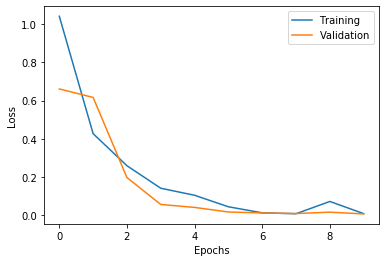

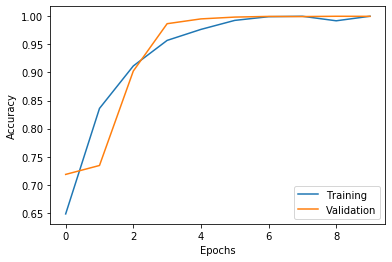

In [30]:
#PLOT TRAIN AND TEST LOSS AND ACCURACY WHILE TRAINING
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

Borrowed from https://machinelearningmastery.com/save-load-keras-deep-learning-models/:

In [31]:
#SAVE MODEL
#Serialize model to JSON:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
#Serialize weights to HDF5:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


Simply evaluate from here instead if you don't want to train the model but just load it instead!

In [12]:
#LOAD MODEL
from keras.models import model_from_json
#Load JSON and create model:
json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
#Load weights into new model:
model.load_weights("model.h5")
print("Loaded model from disk")
#Declare again to support evaluating notebook from here without training again:
img_size = 32
canvas_size = 64
#Zero-aware standard deviation for rescaling, taking "empty" images into account:
smartstd = lambda x: 1 if np.std(x)==0 else np.std(x)

Loaded model from disk


Let's play with the classifier:

<IPython.core.display.Javascript object>


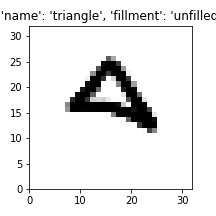

In [38]:
#INTERACTIVE CLASSIFIER EXPERIMENT
from matplotlib import pyplot as plt
import cairo
import numpy as np
%matplotlib notebook
#Reserve image, build white cairo drawing context:
img = np.zeros((img_size, img_size, 4), dtype=np.uint8) #BGRA
surface = cairo.ImageSurface.create_for_data(img, cairo.FORMAT_ARGB32, img_size, img_size)
cr = cairo.Context(surface)
cr.set_source_rgb(1, 1, 1)
cr.paint()
cr.set_source_rgb(0, 0, 0)
#Generate image plot, in such a way that it can be updated by mouse events in Notebook:
fig, ax = plt.subplots(figsize=(3,3))
ax.set(title='Freely draw an image')
im = ax.imshow(img, interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
DoPainting = False
def motion(event):
    if DoPainting:
        #Draw in image:
        cr.arc(event.xdata, event.ydata, 1, 0, 2*np.pi)
        cr.fill()
        im.set_data(img)
        #Also apply classifier and set result as the plot title:
        img_rescaled_1_channel = ((img - np.mean(img)) / np.std(img))[:,:,0:1]
        y_pred = model.predict(np.expand_dims(img_rescaled_1_channel, axis=0))
        ax.set(title=str(shape_labels[np.argmax(y_pred)]))
        #Done, redraw:
        fig.canvas.draw()
def release(event):
    global DoPainting
    DoPainting = False
def press(event):
    global DoPainting
    DoPainting = True
#Connect mouse event handlers and show plot:
fig.canvas.mpl_connect('motion_notify_event', motion)
fig.canvas.mpl_connect('button_press_event', press)     #evaluate this cell until the figure with 
fig.canvas.mpl_connect('button_release_event', release) #"freely draw an image" appears, no idea why it's bugged
plt.show()

Looks good!

Let's play with a sliding-window detector based on the trained classifier:

<IPython.core.display.Javascript object>


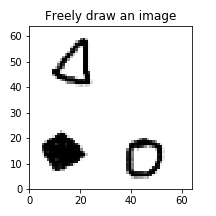

In [40]:
#INTERACTIVE DETECTOR EXPERIMENT INPUT
from matplotlib import pyplot as plt
import cairo
import numpy as np
%matplotlib notebook
#Reserve image, build white cairo drawing context:
canvas = np.zeros((canvas_size, canvas_size, 4), dtype=np.uint8) #BGRA
surface = cairo.ImageSurface.create_for_data(canvas, cairo.FORMAT_ARGB32, canvas_size, canvas_size)
cr = cairo.Context(surface)
cr.set_source_rgb(1, 1, 1)
cr.paint()
cr.set_source_rgb(0, 0, 0)
fig, ax = plt.subplots(figsize=(3,3))
ax.set(title='Freely draw an image')
im = ax.imshow(canvas, interpolation='none', origin='lower', extent=[0, canvas_size, 0, canvas_size])
DoPainting = False
def motion(event):
    if DoPainting:
        #Draw in image:
        cr.arc(event.xdata, event.ydata, 1, 0, 2*np.pi)
        cr.fill()
        im.set_data(canvas)
        #Done, redraw:
        fig.canvas.draw()
def release(event):
    global DoPainting
    DoPainting = False
def press(event):
    global DoPainting
    DoPainting = True
#Connect mouse event handlers and show plot:
fig.canvas.mpl_connect('motion_notify_event', motion)
fig.canvas.mpl_connect('button_press_event', press)     #evaluate this cell until the figure with 
fig.canvas.mpl_connect('button_release_event', release) #"freely draw an image" appears, no idea why it's bugged
plt.show()

In [41]:
#SAVE DETECTOR EXPERIMENT INPUT
np.save("detector_experiment.npy", canvas)

Evaluate from here if not interested in drawing a scenario (evaluate LOAD_MODEL cell above first!)

Ok let's create the detection points using a simple sliding window approach:

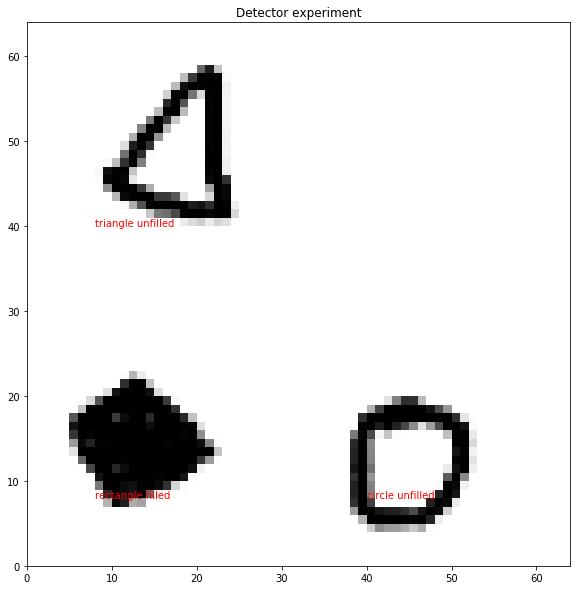

In [179]:
#SLIDING WINDOW DETECTOR EXPERIMENT
from math import *
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
#Load detector experiment input
canvas = np.load("detector_experiment.npy")
#Generate lattice of points the classifier should be applied on:
detector_stride = int(img_size/2)
detection_coordinates = []
for x in range(0,canvas_size, detector_stride):
    for y in range(0,canvas_size, detector_stride):
        if x+img_size <= canvas_size and y+img_size <= canvas_size:
            detection_coordinates.append((x,y))
#Prepare plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set(title='Detector experiment')
detections = []
already_named = set([])
id = 1
imloaded = ax.imshow(canvas, interpolation='none', origin='lower', extent=[0, canvas_size, 0, canvas_size])
#Apply classifier on each coordinate:
for (x,y) in detection_coordinates:
    subimg = canvas[x:x+img_size,y:y+img_size,:]
    subimg_rescaled_1_channel = ((subimg - np.mean(subimg)) / smartstd(subimg))[:,:,0:1]
    y_pred = model.predict(np.expand_dims(subimg_rescaled_1_channel, axis=0))
    name = shape_labels[np.argmax(y_pred)]["name"]
    fillment = "" if name == "" else shape_labels[np.argmax(y_pred)]["fillment"]
    #Determine if a "neighbour" has already be named, avoids multiple detections for same object:
    named = False
    (lx, ly) = (x/detector_stride,y/detector_stride)
    for (lx2, ly2) in already_named:
        #By forcing single choice within certain radius:
        if sqrt((lx-lx2)**2+(ly-ly2)**2)<=1: 
            named = True
            break
    #Plot label that shows detected object type and properties:
    if not named and name != "":
        cordx = x+detector_stride/2
        cordy = y+detector_stride/2
        detections.append(("shape"+str(id)+"",cordy,cordx, shape_labels[np.argmax(y_pred)]))
        id+=1
        plt.text(cordy,cordx, name + " " + fillment, color="red")
    if name != "":
        already_named.add((lx, ly))
#Show the experiment outcome:
plt.show()

In [44]:
detections

[('shape1', 8.0, 8.0, {'name': 'rectangle', 'fillment': 'filled'}),
 ('shape2', 40.0, 8.0, {'name': 'circle', 'fillment': 'unfilled'}),
 ('shape3', 8.0, 40.0, {'name': 'triangle', 'fillment': 'unfilled'})]

As desired!

Let's generate Narsese for NARS (Non-Axiomatic Reasoning System):

In [174]:
#DETECTIONS TO NARSESE CONVERTER
narsese = ""
for (id, x,y,hyperlabel) in detections:
    #Reasoning cycle to digest input before next arrives:
    delay = "1\n"
    #The detected class of the shape:
    narsese += "<{"+id+"} --> "+hyperlabel["name"]+">.\n"+delay
    #The detected fillment property of the shape:
    narsese += "<{"+id+"} --> ["+hyperlabel["fillment"]+"]>.\n"+delay
    #Generate spatial relations between entities as well:
    for (id2, x2,y2,hyperlabel2) in detections:
        if id != id2:
            if x<x2:
                narsese += "<(*,{"+id+"},{"+id2+"}) --> leftOf>.\n"+delay
            if y<y2:
                narsese += "<(*,{"+id+"},{"+id2+"}) --> topOf>.\n"+delay
print(narsese)

<{shape1} --> rectangle>.
1
<{shape1} --> [filled]>.
1
<(*,{shape1},{shape2}) --> leftOf>.
1
<(*,{shape1},{shape3}) --> topOf>.
1
<{shape2} --> circle>.
1
<{shape2} --> [unfilled]>.
1
<(*,{shape2},{shape3}) --> topOf>.
1
<{shape3} --> triangle>.
1
<{shape3} --> [unfilled]>.
1
<(*,{shape3},{shape2}) --> leftOf>.
1



Question to reasoner: What shape is the filled rectangle left to?

In [175]:
question = "<(*,(&,[filled],rectangle),{?1}) --> leftOf>?"

Ok, let's stream this into NARS: (set java executable path, can be from JRE or JDK, Java8 and later!)

In [181]:
#REASONING-BASED QUESTION-ANSWERING EXPERIMENT
java = "/home/tc/Dateien/jdk1.8.0_201/bin/java"
from subprocess import Popen, PIPE, STDOUT
import threading, time
#Write the Narsese to a file, assigning a high priority for the question:
filename = "reasoning_experiment.nal"
file = open(filename, "w")
file.write(narsese+"$1.0;0.99;1.0$ "+question+"\n")
file.close()
#Start OpenNARS:
proc = Popen([java,"-jar", "opennars-3.0.3.jar", "null", "null", filename, "null"], stdin=PIPE, stdout=PIPE)
#Listen for output from OpenNARS to print:
def receive_thread():
    global Running
    Running = True
    while Running:
        print(proc.stdout.readline().decode('UTF-8'))
threading.Thread(target=receive_thread).start()
#Give 10 seconds of time to answer, increase if your question doesn't get answered:
for i in range(10): 
    time.sleep(1.0)
#Terminate thread softly, process violently:
Running = False 
proc.kill()

[l]: creating Nar...

Got relative path for loading the config: ./config/defaultConfig.xml

Loading config defaultConfig.xml from file

[l]: attaching Shell to Nar...

IN: <{shape1} --> rectangle>. %1.00;0.90% {0 : (-7804300880213186698,0)} 

IN: <{shape1} --> [filled]>. %1.00;0.90% {1 : (-7804300880213186698,1)} 

IN: <(*,{shape1},{shape2}) --> leftOf>. %1.00;0.90% {2 : (-7804300880213186698,2)} 

IN: <(*,{shape1},{shape3}) --> topOf>. %1.00;0.90% {3 : (-7804300880213186698,3)} 

IN: <{shape2} --> circle>. %1.00;0.90% {4 : (-7804300880213186698,4)} 

IN: <{shape2} --> [unfilled]>. %1.00;0.90% {5 : (-7804300880213186698,5)} 

IN: <(*,{shape2},{shape3}) --> topOf>. %1.00;0.90% {6 : (-7804300880213186698,6)} 

IN: <{shape3} --> triangle>. %1.00;0.90% {7 : (-7804300880213186698,7)} 

IN: <{shape3} --> [unfilled]>. %1.00;0.90% {8 : (-7804300880213186698,8)} 

IN: <(*,{shape3},{shape2}) --> leftOf>. %1.00;0.90% {9 : (-7804300880213186698,9)} 

IN: <(*,(&,[filled],rectangle),{?1}) --> leftOf

Correct, the filled rectangle is left to Shape2 (which is the unfilled circle)